In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

C:\Users\carlv\AppData\Local\Temp\ipykernel_28460\3338272293.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Game Theory

## Convexity

In [3]:
from src.game_theory_helpers import powerset, is_convex_game, get_loo, get_shapley_value, get_nash_bargaining_solution, get_banzhaf_value, core_nonempty
from helpers.nucleolus.nucleolus import get_nucleolus

In [4]:
import scipy.optimize as opt

def get_nash_bargaining_solution(v: dict, players: list, bargaining_power={}) -> dict:
    """
    Nash bargaining solution for a coalition game.

    v: Characteristic function of the game, must be defined for EVERY coalition
        {frozenset -> float}
    players: list of players
    bargaining_power (optional): bargaining power of each player
        {player -> float}
    """
    # start by extracting status quo point: value of single players
    status_quo = {p: v.get(frozenset({p})) for p in players}
    # add constraint: sum of values must be less than value of grand coalition
    grand_coalition = frozenset(players)
    total = v.get(grand_coalition, 0)
    # construct scipy optimization problem
    if not bargaining_power:
        bargaining_power = {p: 1 for p in players}
    def objective(x):
        prod = 1
        for i, p in enumerate(players):
            prod *= (x[i] - status_quo[p]) ** bargaining_power[p]
        return -prod  # negative for minimization

    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - total}]
    constraints += [{'type': 'ineq', 'fun': lambda x: x[i] - status_quo[p]} for i, p in enumerate(players)]
    result = opt.minimize(objective, x0=list(status_quo.values()), constraints=constraints)
    if not result.success:
        print("ERROR: Optimization failed.")
        raise ValueError("Optimization failed.")
    nash_values = {p: result.x[i] for i, p in enumerate(players)}
    return nash_values

In [5]:
def make_subcoalition_convex(df, players):
    new_df = pd.DataFrame(0, index=df.index, columns=df.columns)
    for idx, row in df.iterrows():
        # make subcoalitions at least value of individual players
        v = {frozenset(k): val for k, val in row.items()}
        v[frozenset()] = 0  # ensure empty set is zero
        if not is_convex_game(v, players):
            # print(f"Warning: Game for {idx} is not convex, adjusting values.")
            for coalition in powerset(players):
                if len(coalition)==len(players) or len(coalition)==0: continue
                coalition_fs = frozenset(coalition)
                for p in coalition:
                    single_fs = frozenset({p})
                    other_players = coalition_fs - single_fs
                    if coalition_fs in v and single_fs in v and other_players in v:
                        v[coalition_fs] = max(v[coalition_fs], v[single_fs] + v[other_players])
        # row = {tuple(k): val for k, val in v.items()}
        row = [val for k, val in v.items() if k != frozenset()]
        # remove empty set entry
        if () in row: del row[()]
        new_df.loc[idx] = row
    return new_df

In [6]:
def add_reward_mechanisms(df: pd.DataFrame, players: list,
                    add_LOO=False, add_nucleolus=True) -> pd.DataFrame:
    """
    Add shapely and nbs values to dataframe df, and optionally LOO and nucleolus.

    df: Dataframe with values for each coalition
    players: list of players
    """
    new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs']))
    if add_LOO:
        new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs', 'loo']))
        if add_nucleolus:
            new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs', 'loo', '0. nucleolus']))
    df_new = pd.DataFrame(pd.NA, index=new_index, columns=df.columns)
    for idx, row in df.iterrows():
        df_new.loc[(idx, 'value')] = row
        v = {frozenset(k): val for k, val in row.items()}
        shapley, nbs = get_shapley_value(v, players), get_nash_bargaining_solution(v, players)
        df_new.loc[(idx, 'shapley'), list((k,) for k in shapley.keys())] = list(shapley.values())
        df_new.loc[(idx, 'nbs'), list((k,) for k in nbs.keys())] = list(nbs.values())
        if add_LOO:
            loo = get_loo(v, players)
            df_new.loc[(idx, 'loo'), list((k,) for k in loo.keys())] = list(loo.values())
        if add_nucleolus:
            is_core_empty = core_nonempty(v, players)
            if not is_core_empty:
                print(f"Core is empty for {idx}, skipping nucleolus computation.")
                continue
            try:
                nucleolus = get_nucleolus(v, players)
                df_new.loc[(idx, '0. nucleolus'), list((k,) for k in nucleolus.keys())] = list(nucleolus.values())
            except Exception as e:
                print(f"Error computing nucleolus for {idx}: {e}")
                # remove the nucleolus row
                # df_new = df_new.drop(index=(idx, 'nucleolus'))
    return df_new

In [7]:
def print_2f_dict(d: dict):
    final_print = ''
    for k, v in d.items():
        final_print += f"{k}: {v:.2f}, "
    return final_print

In [8]:
players = ['A', 'B', 'C']
v = {
    (): 0,
    ('A',): 0,
    ('B',): 0,
    ('C',): 0,
    ('A', 'B'): 100,
    ('A', 'C'): 0,
    ('B', 'C'): 0,
    ('A', 'B', 'C'): 200
}
# convert v to frozenset
v_frozen = {frozenset(k): val for k, val in v.items()}

In [9]:
# test
is_convex_game(v_frozen, players)
core_nonempty(v_frozen, players)
print("LOO: ", get_loo(v_frozen, players, normalized=False))
print("Shapley: ", print_2f_dict(get_shapley_value(v_frozen, players)))
print("NBS :", print_2f_dict(get_nash_bargaining_solution(v_frozen, players)))
print("Banzhaf: ", print_2f_dict(get_banzhaf_value(v_frozen, players)))
print("Nucleolus: ", print_2f_dict(get_nucleolus(v_frozen, players)))

Core is non-empty, one feasible allocation: [200.   0.   0.]
LOO:  {'A': 200, 'B': 200, 'C': 100}
Shapley:  A: 83.33, B: 83.33, C: 33.33, 
NBS : A: 66.67, B: 66.67, C: 66.67, 
Banzhaf:  A: 85.71, B: 85.71, C: 28.57, 
Nucleolus:  A: 75.00, B: 75.00, C: 50.00, 


## Define Plot Function

In [10]:
import matplotlib as mpl

In [11]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")

# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]

# Create extended cycle: first full alpha, then alpha=0.5
colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]

# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\carlv\AppData\Local\Temp\ipykernel_28460\536717058.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [12]:
def visualize_value_results(df_new, df_newstat, calc_convexity=True):
    players = list(str(x[0]) for x in [col for col in df_new.columns if len(col)==1])
    # plot for each service value, shapely and nbs
    for service in df_new.index.get_level_values(0).unique():
        df_plot = df_new.loc[service]
        # drop index rows that are all NaN
        df_plot = df_plot.dropna(axis=0, how='all')
        df_plot = df_plot.transpose()
        df_plot.columns = [col + ' Dynamic PF' for col in df_plot.columns]
        # also add df_newstat values
        if df_newstat is not None:
            df_plot_stat = df_newstat.loc[service]
            df_plot_stat = df_plot_stat.dropna(axis=0, how='all')
            df_plot_stat = df_plot_stat.transpose()
            # remove value column as it is duplicate
            # df_plot_stat = df_plot_stat.loc[:, df_plot_stat.columns != 'value']
            df_plot_stat.columns = [col + ' Static PF' for col in df_plot_stat.columns]
            # combine
            df_plot_total = pd.concat([df_plot, df_plot_stat], axis=1)
        else:
            df_plot_total = df_plot
        df_plot_total = df_plot_total.reindex(sorted(df_plot_total.columns, reverse=True), axis=1)
        # 1st plot: only the players
        df_plot = df_plot_total.iloc[:len(players)]

        plt.figure()

        ax = df_plot.plot(kind='bar', figsize=(10, 6),
                        title=f'Service: {service} - Individual Value, Shapley and NBS', ylabel='Value in €')
        
        
        plt.grid()
        plt.xticks(rotation=0)
        # show numbers above bars
        for p in ax.patches:
            if p.get_height() >= 0:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, 1.03 * p.get_height()),
                            ha='center', va='bottom', rotation=90, fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, df_plot.max().max()+3)
        plt.show()

        # 2nd plot: all coalitions
        plt.figure()
        # drop na columns
        df_plot = df_plot_total.dropna(axis=1, how='any')
        # add two new index rows: Grand-C Convex Game? and Convex Game?

        # add convexity where there is  empty coalition
        if calc_convexity:
            df_plot = pd.concat([df_plot, pd.DataFrame(0, index=['Core non-empty?', 'Convex Game?'], columns=df_plot.columns)], axis=0)
            v1 = {frozenset(k): val for k, val in df_new.loc[service].loc['value'].items()}
            v1[frozenset()] = 0  # ensure empty coalition is present
            if df_newstat is not None:
                v2 = {frozenset(k): val for k, val in df_newstat.loc[service].loc['value'].items()}
                v2[frozenset()] = 0  # ensure empty coalition is present
                # create df and append
                df_plot.loc['Core non-empty?', 'value Static PF'] = float(core_nonempty(v2, players))
                df_plot.loc['Convex Game?', 'value Static PF'] = float(is_convex_game(v2, players))

            df_plot.loc['Core non-empty?', 'value Dynamic PF'] = float(core_nonempty(v1, players))
            df_plot.loc['Convex Game?', 'value Dynamic PF'] = float(is_convex_game(v1, players))
            
        
        
        ax = df_plot.plot(kind='bar', figsize=(10, 6),
                        title=f'Service: {service} - Value of Coalitions', ylabel='Value in €')
        plt.grid()
        plt.xticks(rotation=0)
        # show numbers above bars
        for p in ax.patches:
            if p.get_height() >= 0:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, 1.03 * p.get_height()),
                            ha='center', va='bottom', rotation=90, fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, df_plot.max().max()+3)
        plt.show()


## DVPP1

no stochastic production, just 1MW of PV, Wind, BESS each

**IO_dict =      {'PV': (get_pv_sys(), 'lpf', 1),
                'Wind': (get_wind_sys(), 'lpf', 1),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                }**

In [75]:
# load data
# df = pd.read_csv('pics/new/values.csv', index_col=0, header=[0,1,2])
n_players = 3
df = pd.read_csv('pics/v1/values_dyn.csv', index_col=0, header=list(range(n_players)))
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
players = list(str(x[0]) for x in df.columns[:n_players])

df.dropna(inplace=True)
df = df.astype(float)
df[df < 0] = 0  # set values below zero to zero
df

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,12.37032,12.13886,0.00000,24.27771,12.37032,12.37032,24.74064
FFR,1.13156,0.89878,4.66527,2.03035,5.73864,5.59315,6.60833
FFR-FCR,4.73210,3.80625,0.00000,8.07543,11.67593,11.90740,23.81479
FCR-D,12.60178,12.60178,0.00000,25.20356,12.60178,12.60178,25.20356


In [76]:
# also load static pf values
dfstat = pd.read_csv('pics/v1/values_stat.csv', index_col=0, header=[0,1,2])
dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
dfstat[dfstat < 0] = 0  # set values below zero to zero
dfstat

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,12.37032,12.13886,0.00000,24.27771,6.12086,6.12086,16.40803
FFR,1.13156,0.89878,4.66527,2.03035,5.01121,4.86572,5.79360
FFR-FCR,4.73210,3.80625,0.00000,8.53835,6.12086,6.12086,16.40803
FCR-D,12.60178,12.60178,0.00000,25.20356,7.27817,7.27817,19.18557


In [77]:
print('Computing Reward Mechanisms for Dynamic')
df_new = add_reward_mechanisms(df, players, add_LOO=True)
print('Computing Reward Mechanisms for Static')
df_newstat = add_reward_mechanisms(dfstat, players, add_LOO=True)

Computing Reward Mechanisms for Dynamic
Core is non-empty, one feasible allocation: [12.37032 12.37032  0.     ]
Core is empty for FFR, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [11.90739 11.9074   0.     ]
Core is non-empty, one feasible allocation: [12.60178 12.60178  0.     ]
Computing Reward Mechanisms for Static
Core is empty for FCR, skipping nucleolus computation.
Core is empty for FFR, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [10.28717  6.12086  0.     ]
Core is empty for FCR-D, skipping nucleolus computation.


In [78]:
df_v1 = df_new.copy()
df_v1stat = df_newstat.copy()

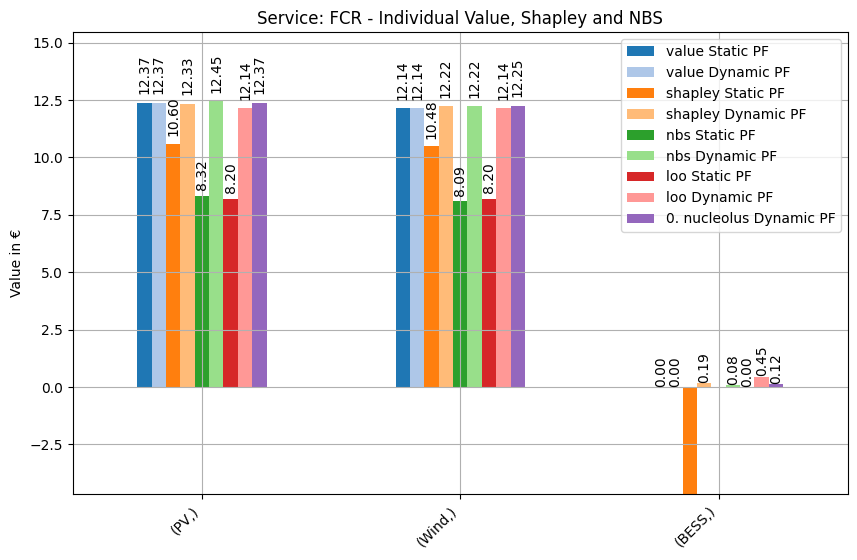

Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Core is non-empty, one feasible allocation: [12.37032 12.37032  0.     ]
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

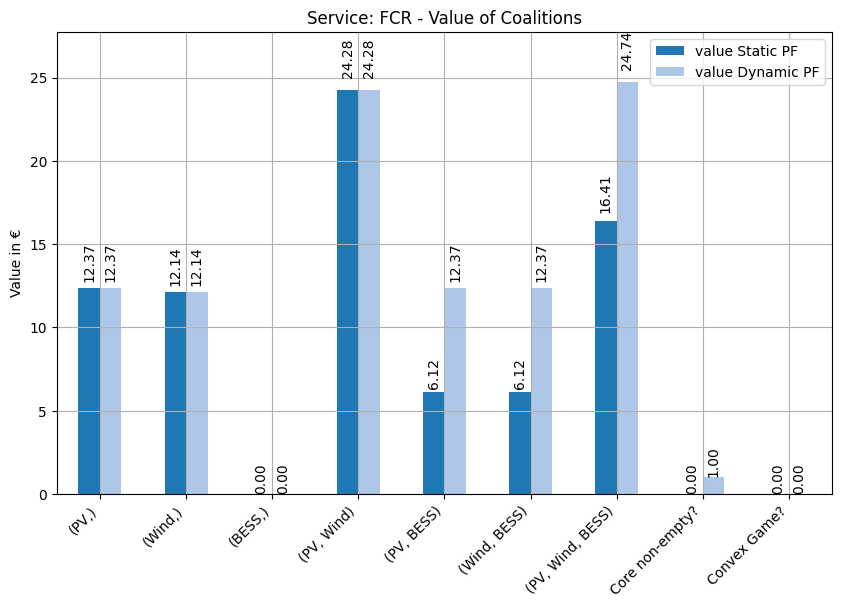

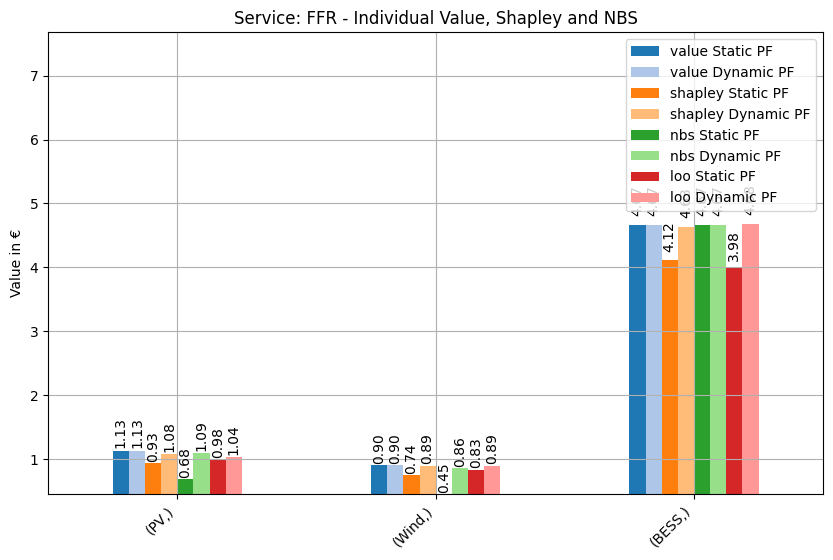

Game is not convex: frozenset({'PV'}), frozenset({'BESS'})
Game is not convex: frozenset({'PV'}), frozenset({'BESS'})


<Figure size 640x480 with 0 Axes>

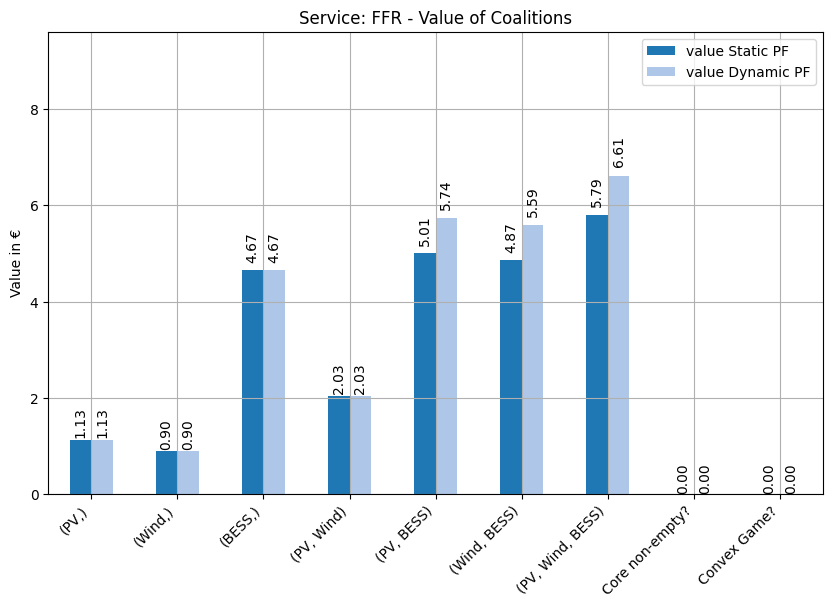

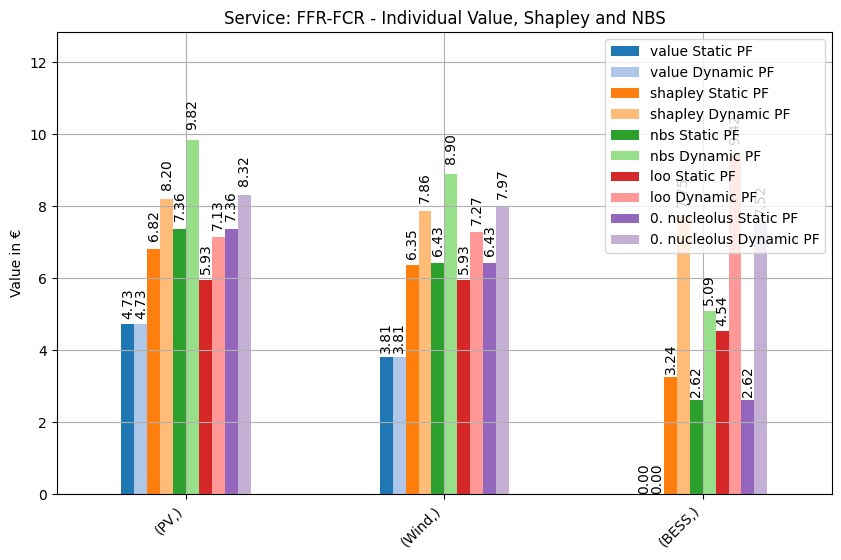

Core is non-empty, one feasible allocation: [10.28717  6.12086  0.     ]
Core is non-empty, one feasible allocation: [11.90739 11.9074   0.     ]
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

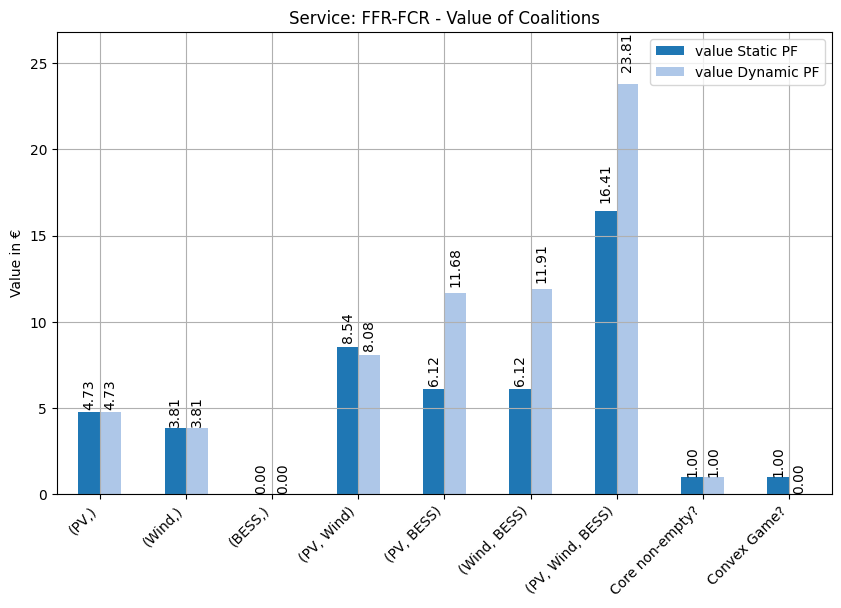

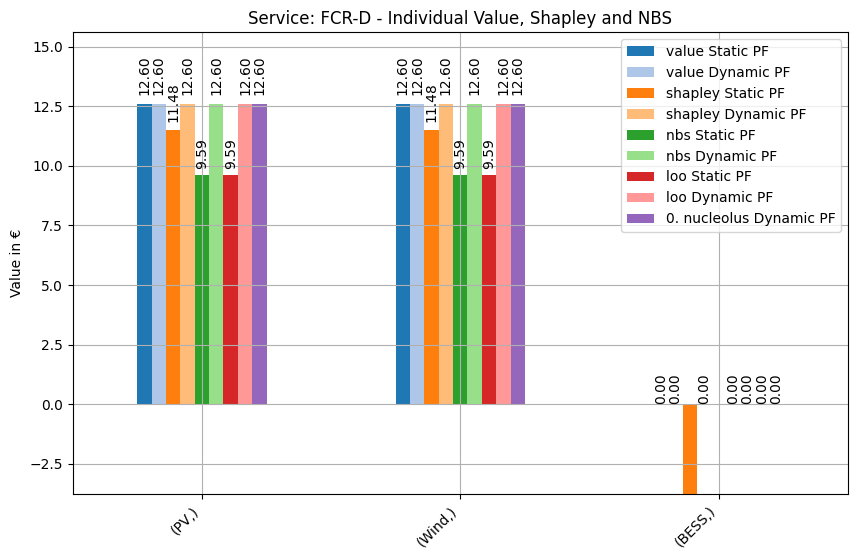

Game is not convex: frozenset({'PV'}), frozenset({'BESS'})
Core is non-empty, one feasible allocation: [12.60178 12.60178  0.     ]


<Figure size 640x480 with 0 Axes>

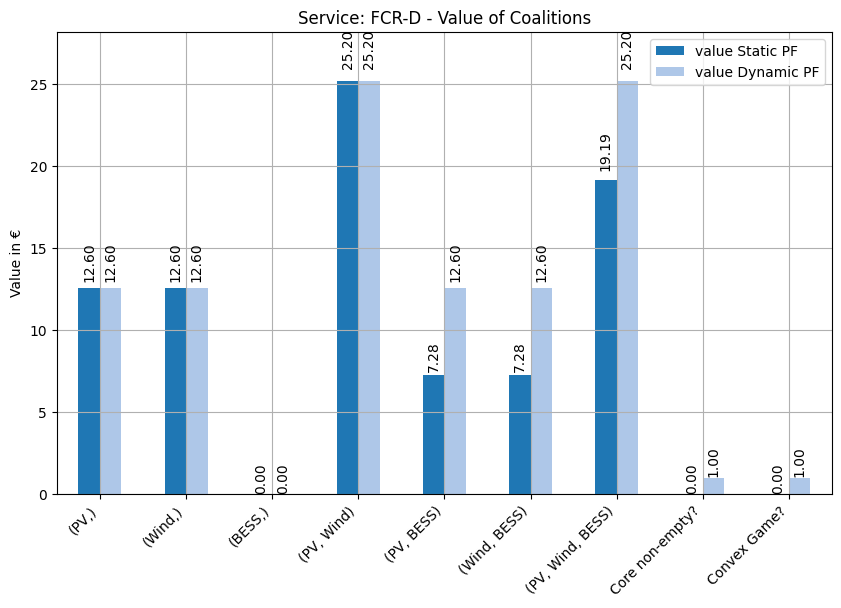

In [80]:
visualize_value_results(df_new, df_newstat)

## DVPP2

stochastic production of PV, BESS Wind with 

IO_dict =      {'PV': (get_pv_sys(), 'lpf', 2),
                'Wind': (get_wind_sys(), 'lpf', 1.5),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                }

In [13]:
# load data
# df = pd.read_csv('pics/new/values.csv', index_col=0, header=[0,1,2])
df = pd.read_csv('pics/v2/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]

# df[df < 0] = 0  # set values below zero to zero
# combine 1st col and index to MultiIndex
df.index = pd.MultiIndex.from_arrays([df.index, df.iloc[:, 0]], names=['Service', 'Scenario'])
df.drop(df.columns[0], axis=1, inplace=True)  # drop first column
players = list(str(x[0]) for x in df.columns[:3])
df.head()

# df_mean = df.groupby('Service').mean() # probably this line causes the trouble

(PV,)  (Wind,)  (BESS,)  (PV, Wind)  (PV, BESS)  \
Service Scenario                                                      
FCR     0        -0.81408  0.86945 -0.81408     0.86945    -0.81675   
        1         2.12802  1.47138 -1.78754     3.66020     1.99594   
        2        -0.79915  0.80459 -0.79915     0.80459    -0.80089   
        3         3.61030  2.82735 -3.19708     6.54640     3.53878   
        4        -2.01900  2.15635 -2.01900     2.15635    -2.01900   

                  (Wind, BESS)  (PV, Wind, BESS)  
Service Scenario                                  
FCR     0              0.89097           0.89318  
        1              1.44128           3.61890  
        2              0.79652           0.79784  
        3              2.84406           6.46017  
        4              2.22101           2.22101

In [14]:
all_scenarios = []
for sc in df.index.get_level_values(1).unique():
    scenario_df = df.xs(sc, level='Scenario')
    scenario_df = make_subcoalition_convex(scenario_df, players)
    # compute reward mechanisms
    # scenario_df_new = add_reward_mechanisms(scenario_df, players, add_LOO=True)
    all_scenarios.append(scenario_df)
# now mean over all scnenarios
df_new = pd.concat(all_scenarios).groupby(level=0).mean()

C:\Users\carlv\AppData\Local\Temp\ipykernel_28460\2593672234.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.81408' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[idx] = row
C:\Users\carlv\AppData\Local\Temp\ipykernel_28460\2593672234.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.86945' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[idx] = row
C:\Users\carlv\AppData\Local\Temp\ipykernel_28460\2593672234.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.81675' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[idx] = row
C:\Users\carlv\AppData\Local\Temp\ipykernel_284

In [19]:
df_final = add_reward_mechanisms(df_new, players, add_LOO=True)

Core is empty for FCR, skipping nucleolus computation.
Core is empty for FCR-D, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [0.282123 0.358155 5.174862]
Core is non-empty, one feasible allocation: [1.297296 1.685116 0.      ]


In [122]:
# df_final = all_scenarios[0]
# for df in all_scenarios[1:]:
#     df_final = df_final.add(df, fill_value=0)
# df_final = df_final / len(all_scenarios)
# df_final

In [32]:
# # also load static pf values
# dfstat = pd.read_csv('pics/v2/values_stat.csv', index_col=0, header=[0,1,2])
# dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
# players = list(dfstat.columns[-2])
# dfstat[dfstat < 0] = 0  # set values below zero to zero
# # combine 1st col and index to MultiIndex
# dfstat.index = pd.MultiIndex.from_arrays([dfstat.index, df.iloc[:, 0]], names=['Service', 'Scenario'])
# dfstat.drop(dfstat.columns[0], axis=1, inplace=True)  # drop first column
# players = list(str(x[0]) for x in dfstat.columns[:3])

# dfstst_mean = dfstat.groupby(level=0).mean()

In [54]:
# df_new = add_reward_mechanisms(df_mean, players, add_LOO=True)
# todo: run static
# df_newstat = add_reward_mechanisms(dfstst_mean, players, add_LOO=True)

In [ ]:
df_v2 = df_final.copy()
# df_v2stat = df_newstat.copy()

<Figure size 640x480 with 0 Axes>

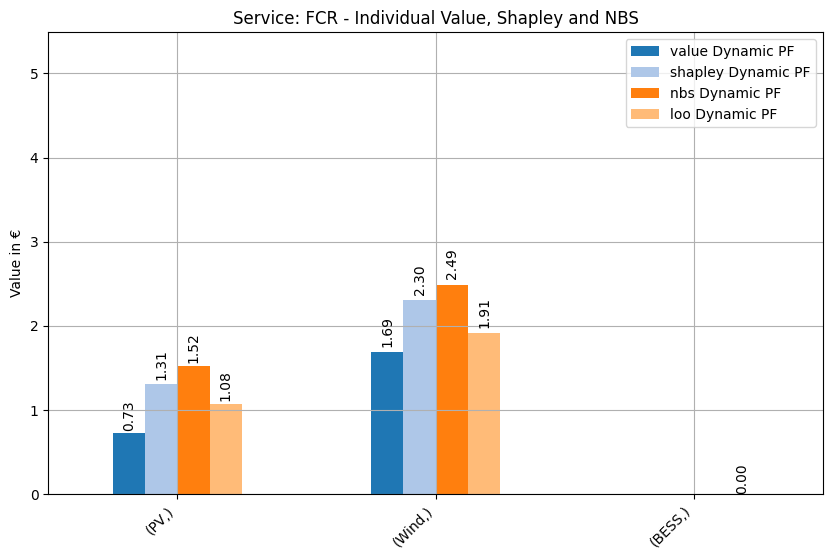

<Figure size 640x480 with 0 Axes>

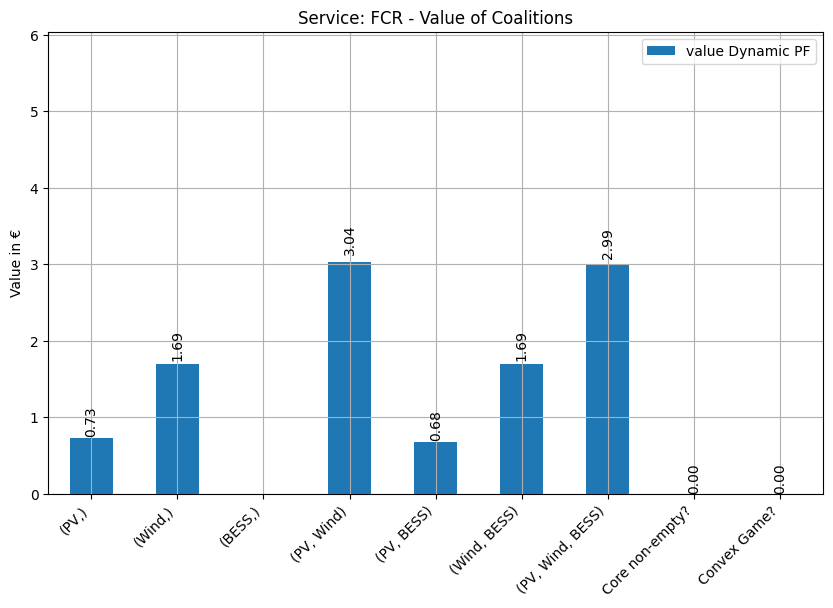

<Figure size 640x480 with 0 Axes>

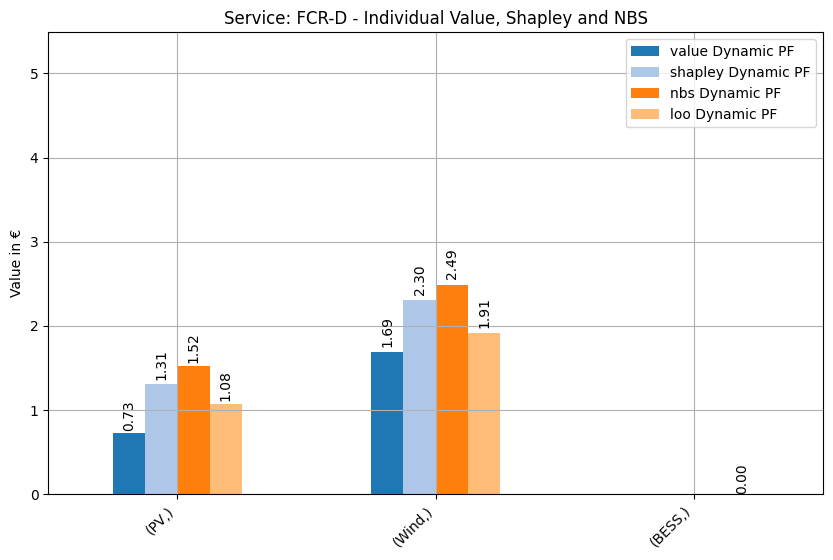

<Figure size 640x480 with 0 Axes>

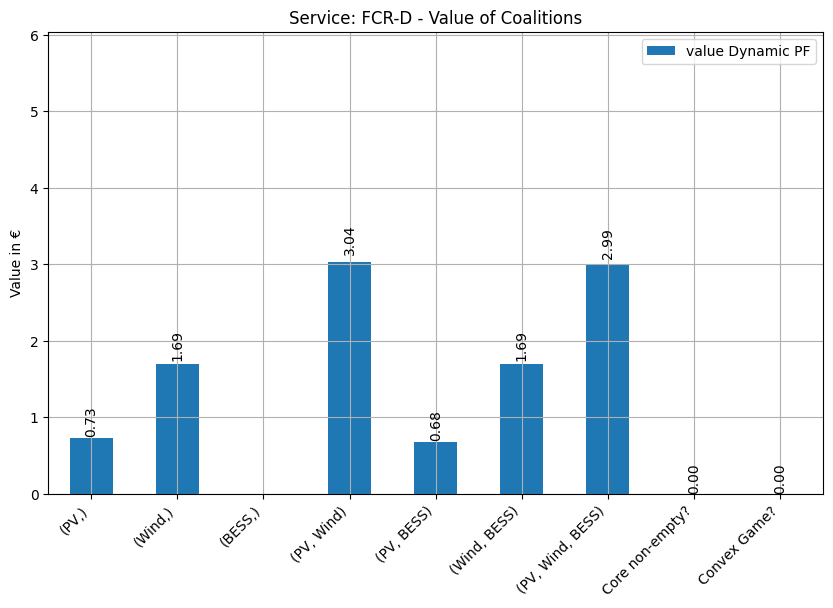

<Figure size 640x480 with 0 Axes>

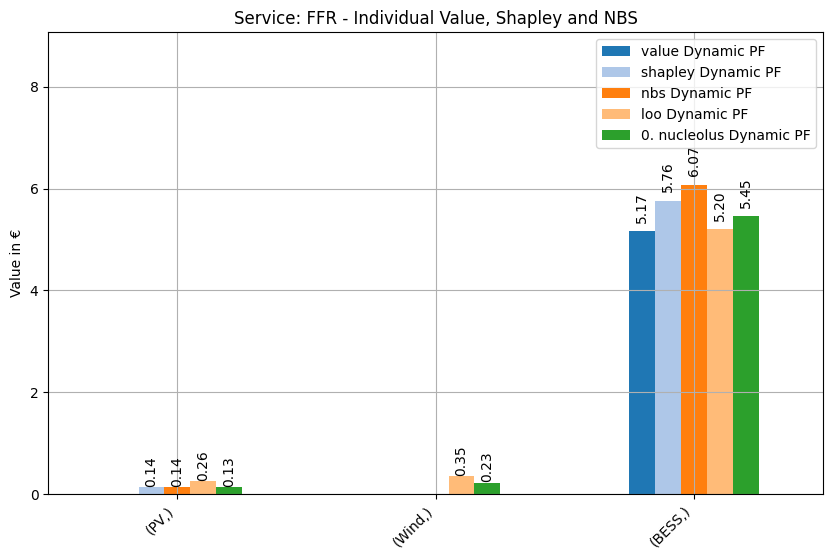

Core is non-empty, one feasible allocation: [0.282123 0.358155 5.174862]


<Figure size 640x480 with 0 Axes>

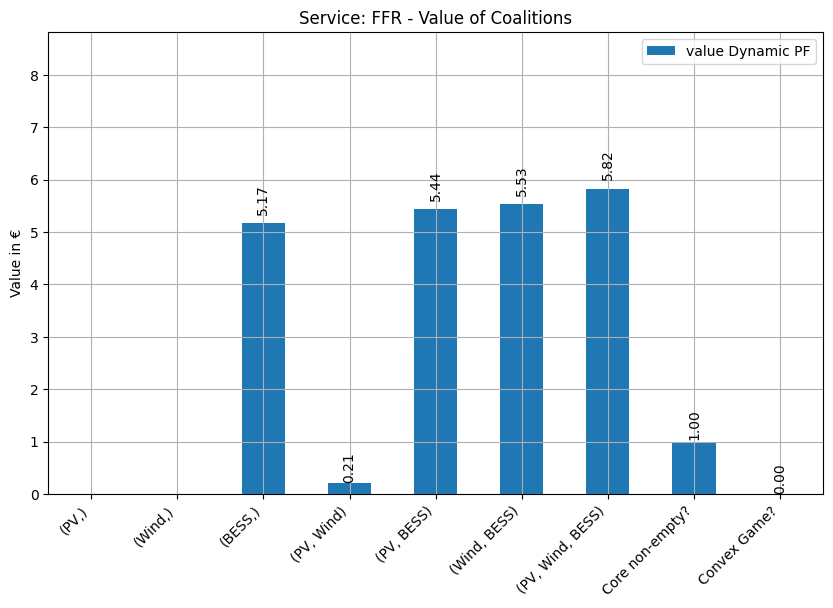

<Figure size 640x480 with 0 Axes>

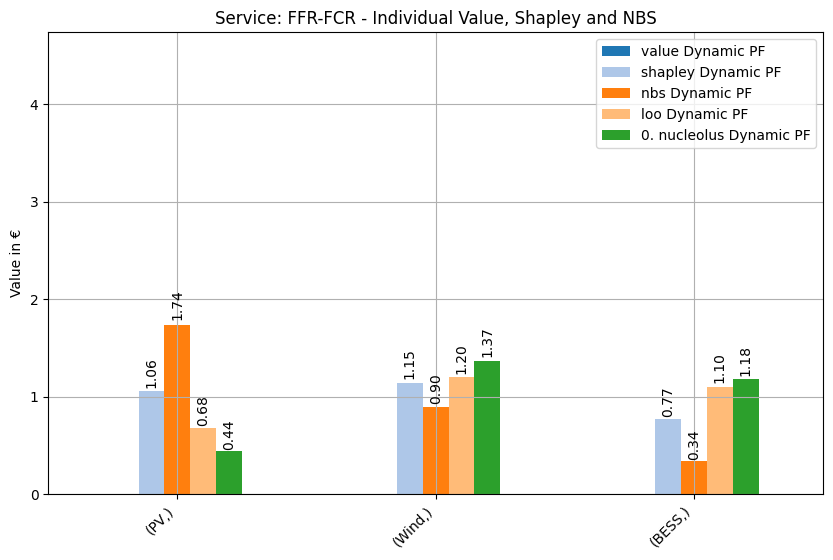

Core is non-empty, one feasible allocation: [1.297296 1.685116 0.      ]


<Figure size 640x480 with 0 Axes>

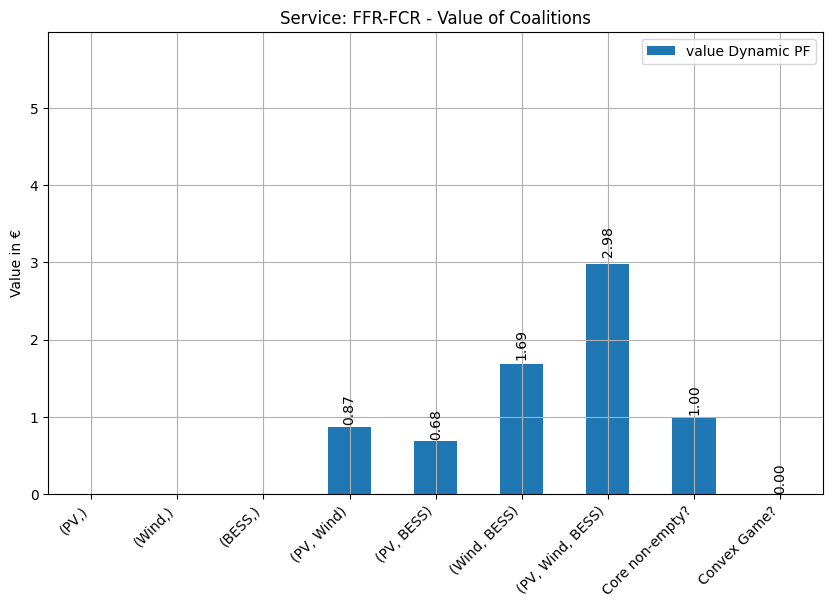

In [20]:
# visualize:
visualize_value_results(df_final, None)

## DVPP Hydro-Bess-SC (todo)

no stochastic production, 1MW of

**IO_dict = {'Hydro': (get_hydro_tf(), 'lpf', 1),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                'SC': (get_sc_io_sys(t_drop=5), 'hpf', 1),
                }**

In [57]:
# load data
df = pd.read_csv('pics/vh1/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
players = [str(x[0]) for x in df.columns[:3]]
df[df < 0] = 0  # set values below zero to zero
df

,"(Hydro,)","(BESS,)","(SC,)","(Hydro, BESS)","(Hydro, SC)","(BESS, SC)","(Hydro, BESS, SC)"
FCR,0.0,0.00000,0.00000,9.18130,3.62623,0.00000,9.18130
FFR,0.0,3.16838,0.60781,2.64462,0.43323,3.16838,3.11018
FFR-FCR,0.0,0.00000,0.00000,9.52849,0.00000,0.00000,9.52849
FCR-D,0.0,0.00000,0.00000,11.26445,5.70938,0.00000,11.26445


In [58]:
# also load static pf values
dfstat = pd.read_csv('pics/vh1/values_stat.csv', index_col=0, header=[0,1,2])
dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
players_stat = players
dfstat[dfstat < 0] = 0  # set values below zero to zero
dfstat

,"(Hydro,)","(BESS,)","(SC,)","(Hydro, BESS)","(Hydro, SC)","(BESS, SC)","(Hydro, BESS, SC)"
FCR,0.0,0.00000,0.0,12.37032,6.12086,6.12086,8.20402
FFR,0.0,3.16838,0.0,2.49590,0.00000,3.12958,1.87516
FFR-FCR,0.0,0.00000,0.0,5.19502,2.41748,6.12086,6.81525
FCR-D,0.0,0.00000,0.0,12.60178,7.04671,7.27817,9.59278


In [59]:
df_new = add_reward_mechanisms(df, players, add_LOO=True)
df_newstat = add_reward_mechanisms(dfstat, players, add_LOO=True)

Core is non-empty, one feasible allocation: [9.1813 0.     0.    ]
Core is empty for FFR, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [9.52849 0.      0.     ]
Core is non-empty, one feasible allocation: [11.26445  0.       0.     ]
Core is empty for FCR, skipping nucleolus computation.
Core is empty for FFR, skipping nucleolus computation.
Core is empty for FFR-FCR, skipping nucleolus computation.
Core is empty for FCR-D, skipping nucleolus computation.


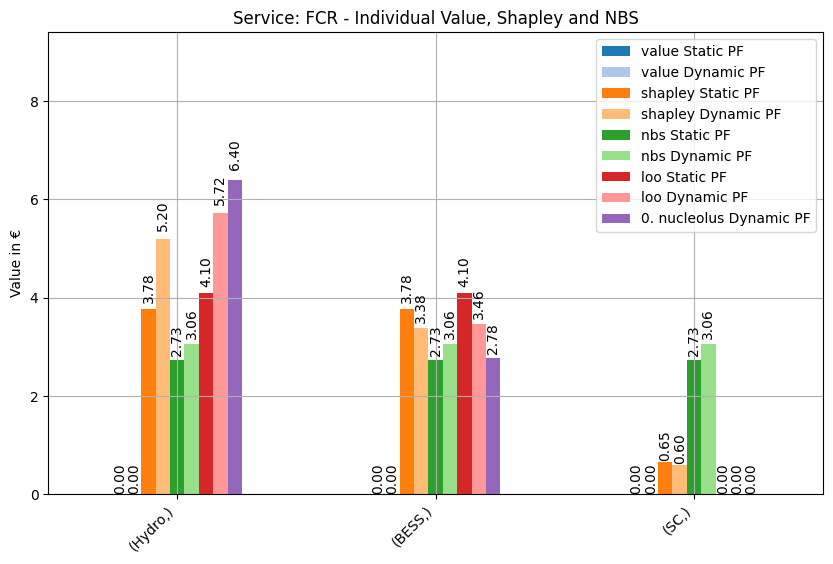

Game is not convex: frozenset({'SC'}), frozenset({'BESS', 'Hydro'})
Core is non-empty, one feasible allocation: [9.1813 0.     0.    ]
Game is not convex: frozenset({'BESS', 'Hydro'}), frozenset({'SC', 'Hydro'})


<Figure size 640x480 with 0 Axes>

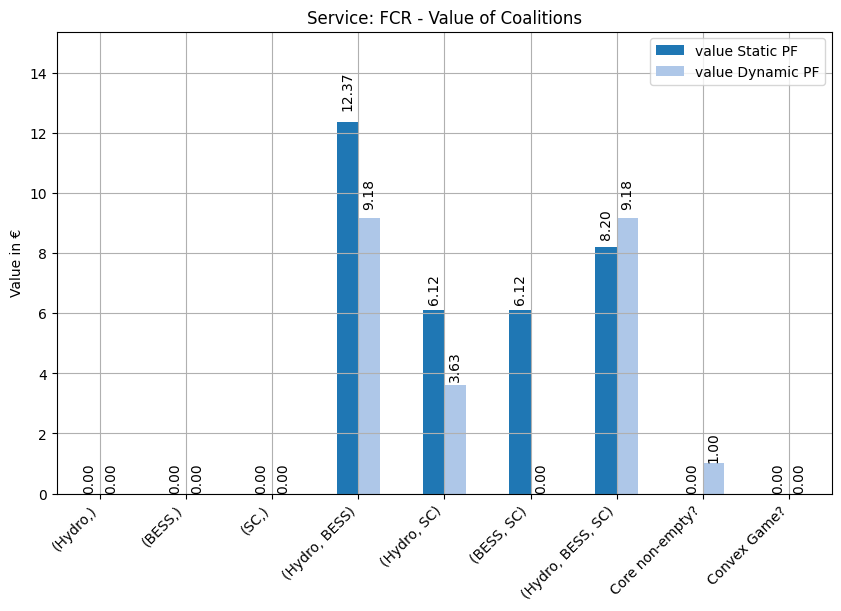

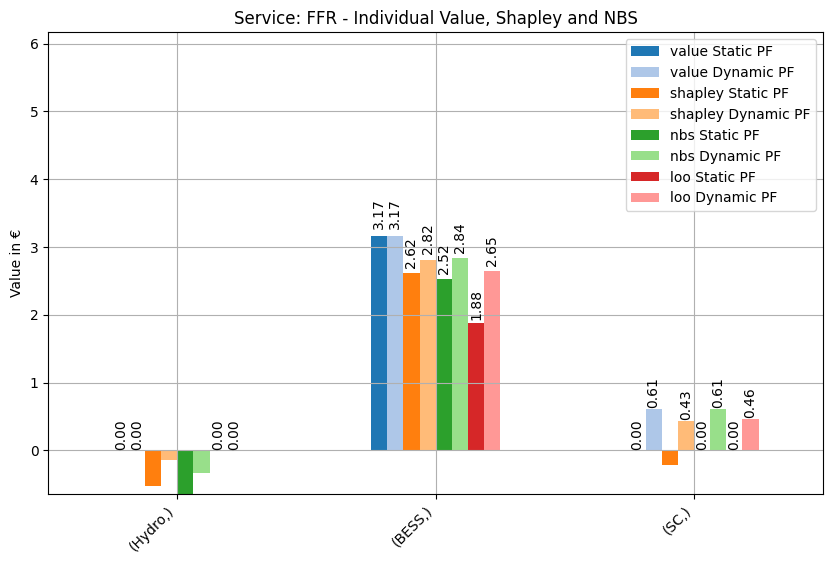

Game is not convex: frozenset({'Hydro'}), frozenset({'BESS'})
Game is not convex: frozenset({'Hydro'}), frozenset({'BESS'})


<Figure size 640x480 with 0 Axes>

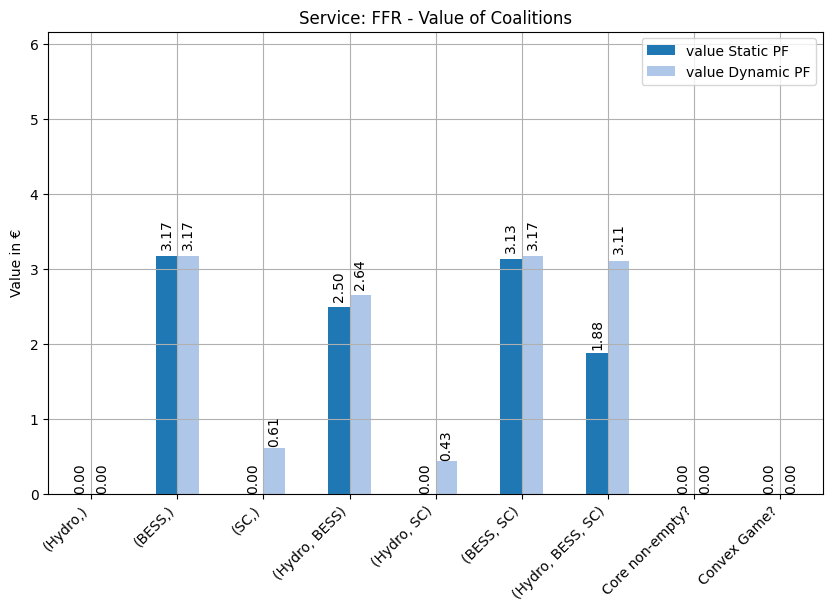

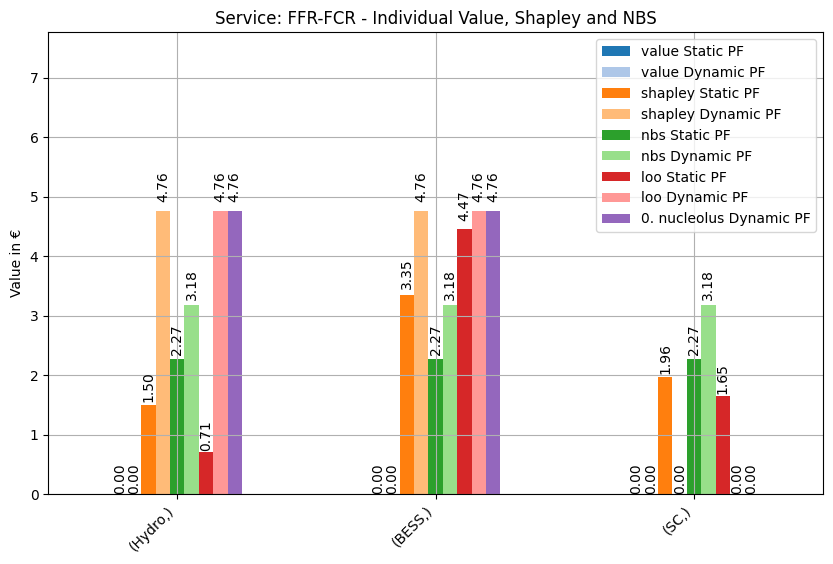

Game is not convex: frozenset({'BESS', 'Hydro'}), frozenset({'SC', 'Hydro'})
Core is non-empty, one feasible allocation: [9.52849 0.      0.     ]


<Figure size 640x480 with 0 Axes>

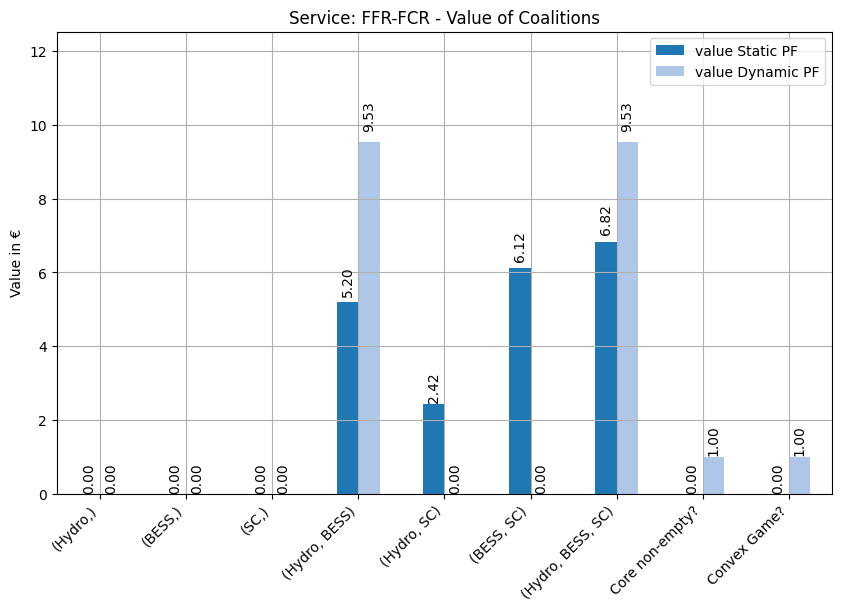

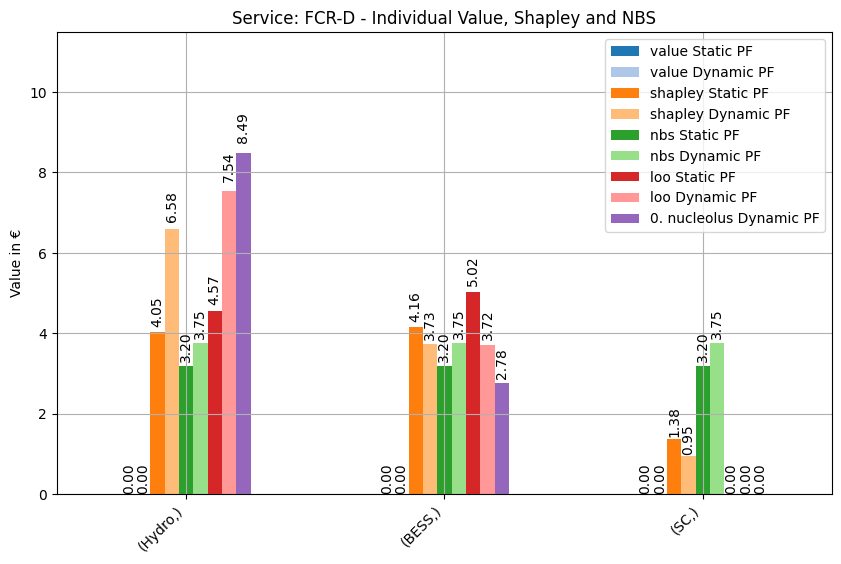

Game is not convex: frozenset({'SC'}), frozenset({'BESS', 'Hydro'})
Core is non-empty, one feasible allocation: [11.26445  0.       0.     ]
Game is not convex: frozenset({'BESS', 'Hydro'}), frozenset({'SC', 'Hydro'})


<Figure size 640x480 with 0 Axes>

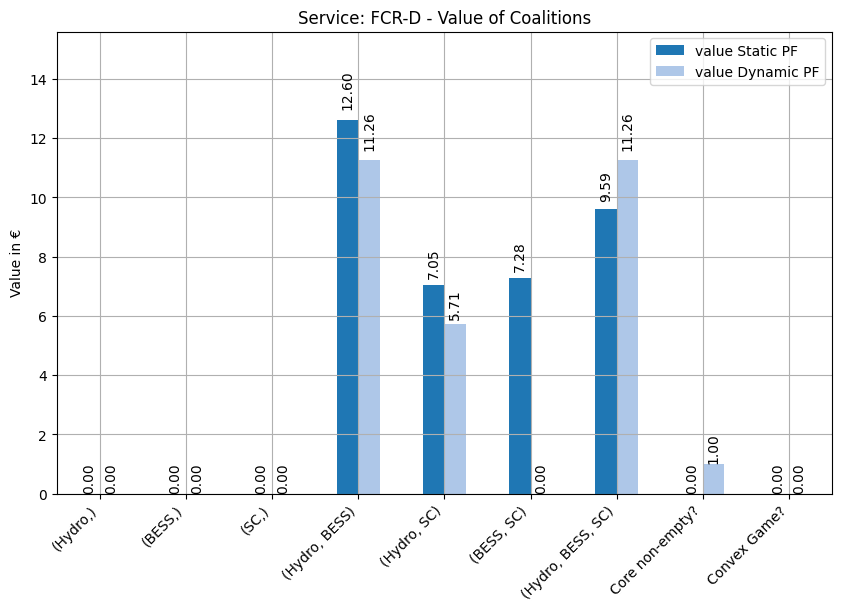

In [60]:
visualize_value_results(df_new, df_newstat)

## DVPP3

Using adpative dynamic PF (ADPF) with setttings 

{'PV': (get_pv_sys(), 'lpf', 1),
                'Wind': (get_wind_sys(), 'lpf', 1),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                }
    
def adaptive_pv_func(t):
    return .3 + .7 * np.sin(t / 5)**2

def adaptive_wind_func(t):
    return .3 + .7 * np.cos(t / 5 + .5)**2

In [39]:
# load data
df = pd.read_csv('pics/v3/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]

df[df < 0] = 0  # set values below zero to zero
df

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,0.00000,12.13886,0.00000,12.24173,12.60178,12.37032,24.74064
FFR,1.13156,0.89878,3.16838,0.00000,0.00000,0.00000,4.96594
FFR-FCR,0.00000,3.80625,0.00000,8.07543,11.90740,11.90740,20.11141
FCR-D,0.00000,12.60178,0.00000,14.55634,0.00000,12.60178,14.55634


In [40]:
df_stat = pd.read_csv('pics/v3/values_stat.csv', index_col=0, header=[0,1,2])
df_stat.columns = [tuple(c for c in col if c!='nan') for col in df_stat.columns.values]

df_stat[df_stat < 0] = 0  # set values below zero to zero
df_stat

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,0.00000,12.13886,0.00000,12.24173,6.12086,12.13886,16.40803
FFR,1.13156,0.89878,3.16838,1.91396,4.24174,4.00897,4.96594
FFR-FCR,0.00000,3.80625,0.00000,7.61250,6.12086,8.20402,14.09342
FCR-D,0.00000,12.60178,0.00000,14.55634,7.27817,12.60178,19.18557


In [41]:
players = list(str(x[0]) for x in df.columns[:3])

In [42]:
df_new = add_reward_mechanisms(df, players, add_LOO=True)
df_newstat = add_reward_mechanisms(df_stat, players, add_LOO=True)

Core is non-empty, one feasible allocation: [12.37032 12.13886  0.23146]
Core is empty for FFR, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [8.20401 8.20401 3.70339]
Core is non-empty, one feasible allocation: [ 1.95456 12.60178  0.     ]
Core is empty for FCR, skipping nucleolus computation.
Core is empty for FFR, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [5.8894  7.97256 0.23146]
Core is empty for FCR-D, skipping nucleolus computation.


In [43]:
df_v2A = df_new.copy()
df_v2Astat = df_newstat.copy()

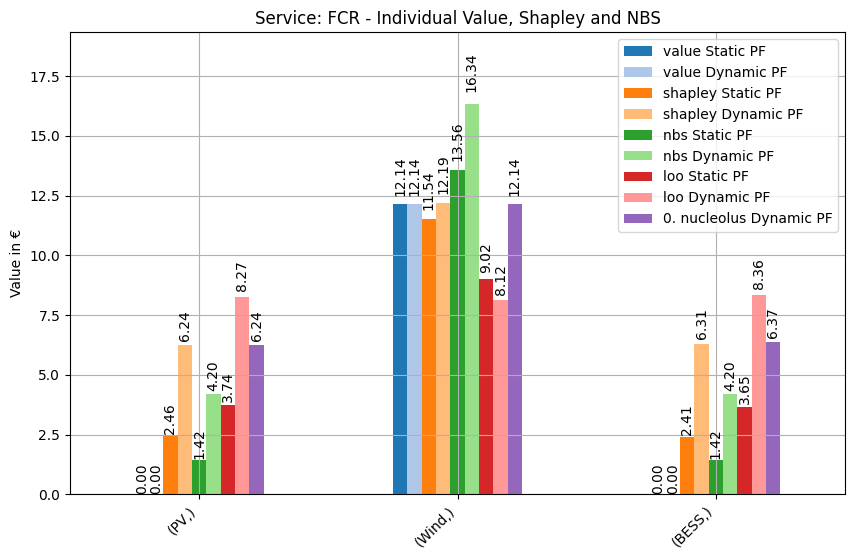

Game is not convex: frozenset({'Wind'}), frozenset({'BESS', 'PV'})
Core is non-empty, one feasible allocation: [12.37032 12.13886  0.23146]
Game is not convex: frozenset({'Wind', 'PV'}), frozenset({'BESS', 'PV'})


<Figure size 640x480 with 0 Axes>

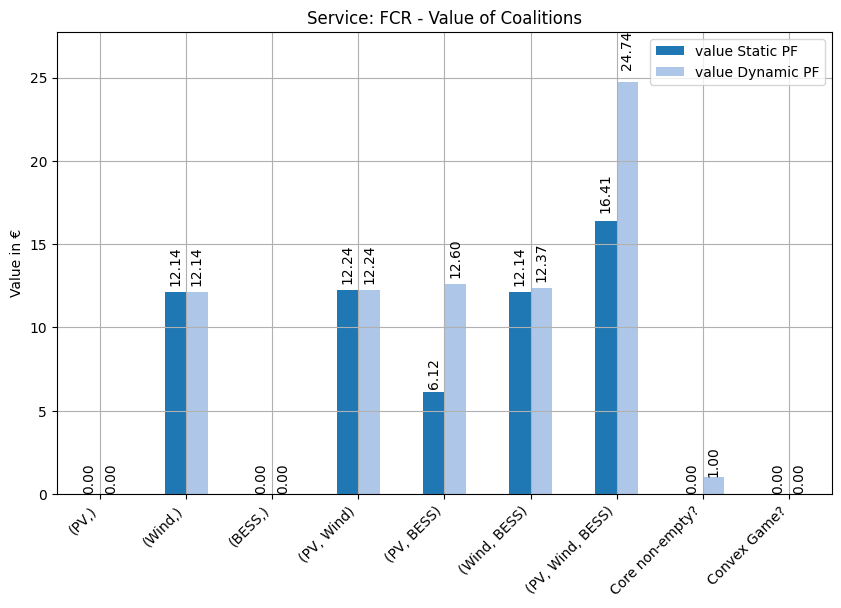

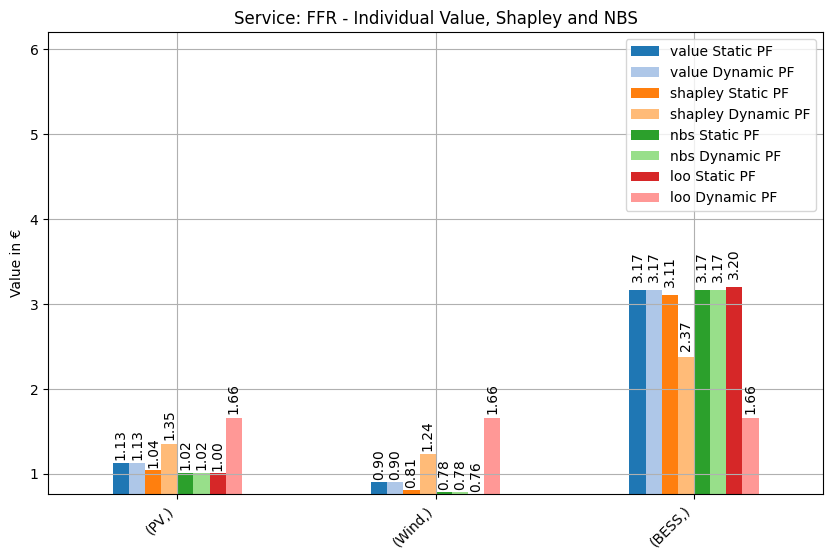

Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

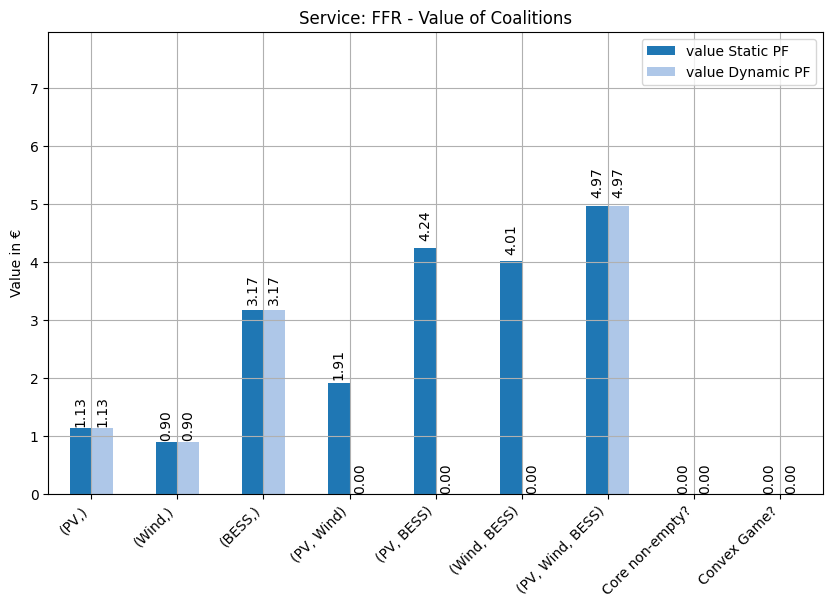

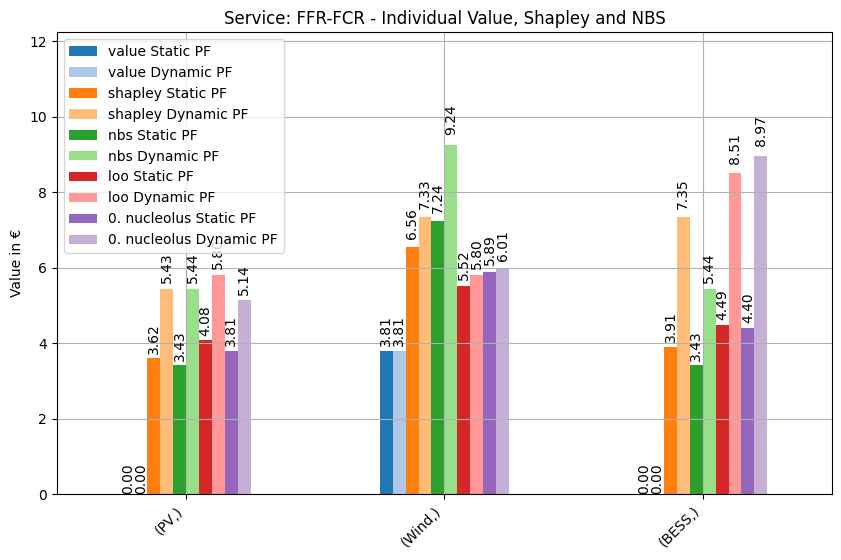

Core is non-empty, one feasible allocation: [5.8894  7.97256 0.23146]
Game is not convex: frozenset({'BESS', 'PV'}), frozenset({'BESS', 'Wind'})
Core is non-empty, one feasible allocation: [8.20401 8.20401 3.70339]
Game is not convex: frozenset({'BESS', 'PV'}), frozenset({'BESS', 'Wind'})


<Figure size 640x480 with 0 Axes>

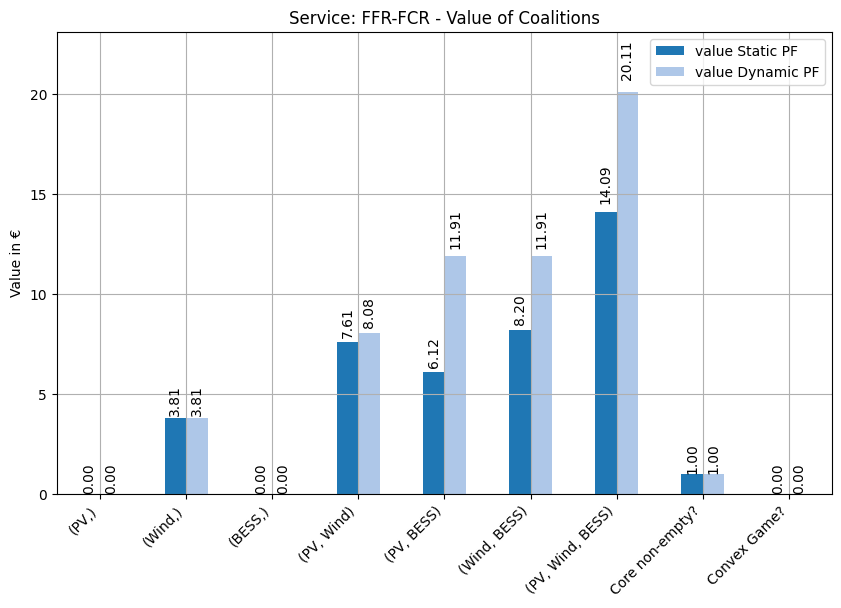

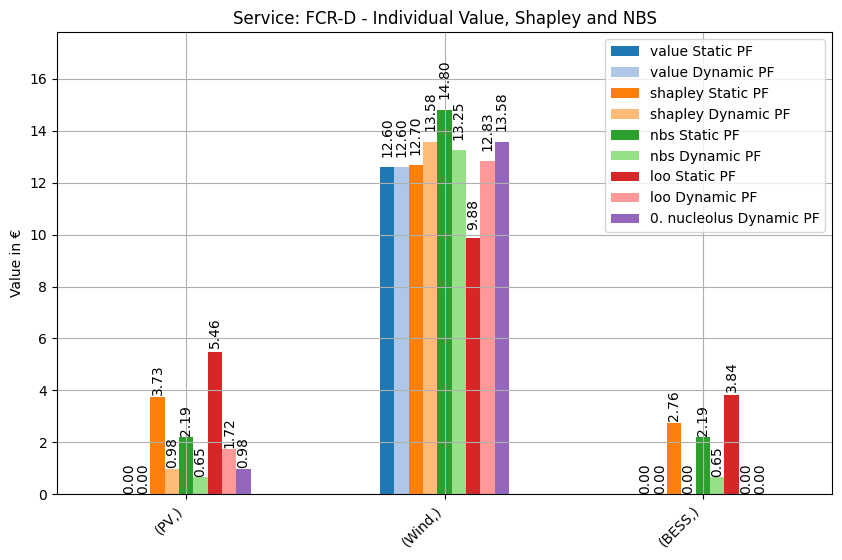

Game is not convex: frozenset({'Wind'}), frozenset({'BESS', 'PV'})
Core is non-empty, one feasible allocation: [ 1.95456 12.60178  0.     ]


<Figure size 640x480 with 0 Axes>

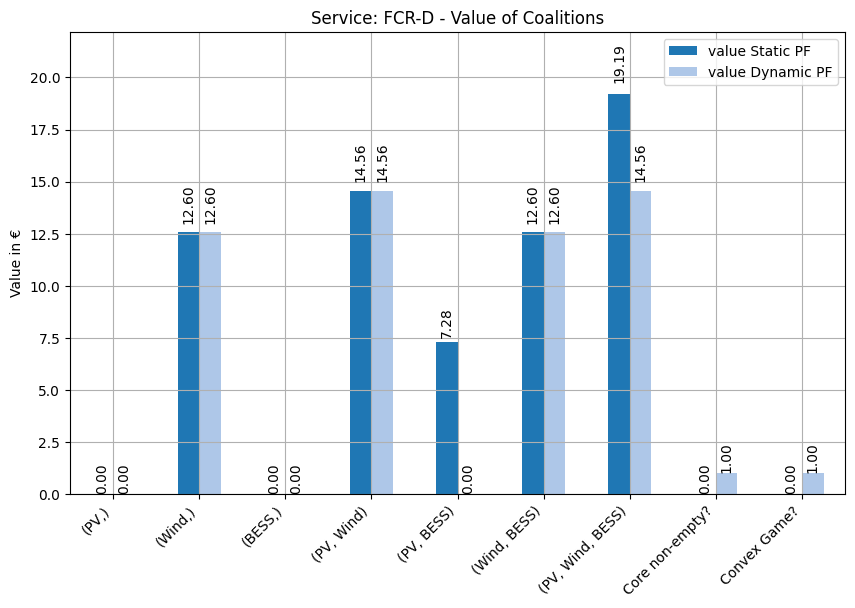

In [44]:
visualize_value_results(df_new, df_newstat)

## compare scenarios

### NBS

<Figure size 640x480 with 0 Axes>

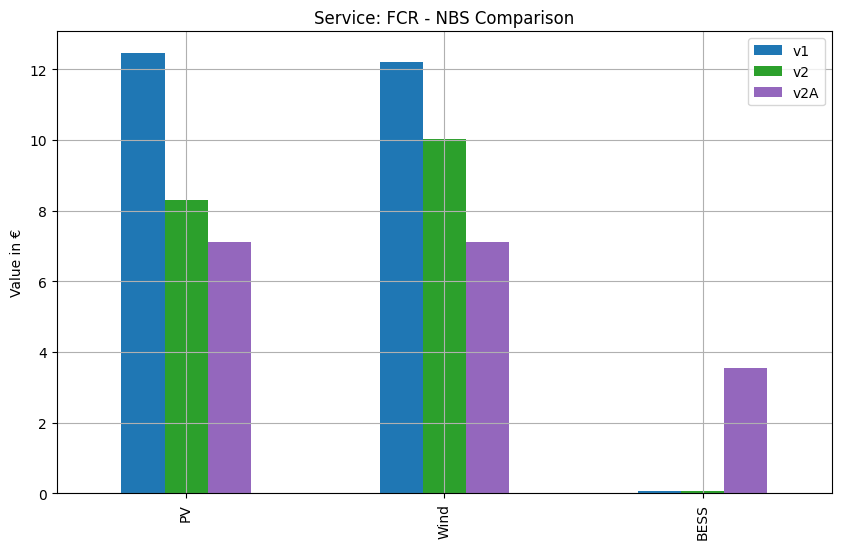

<Figure size 640x480 with 0 Axes>

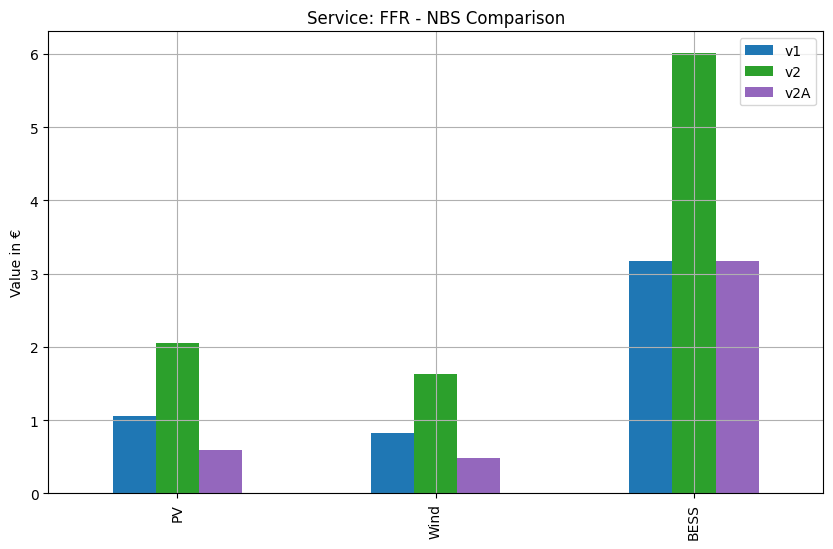

<Figure size 640x480 with 0 Axes>

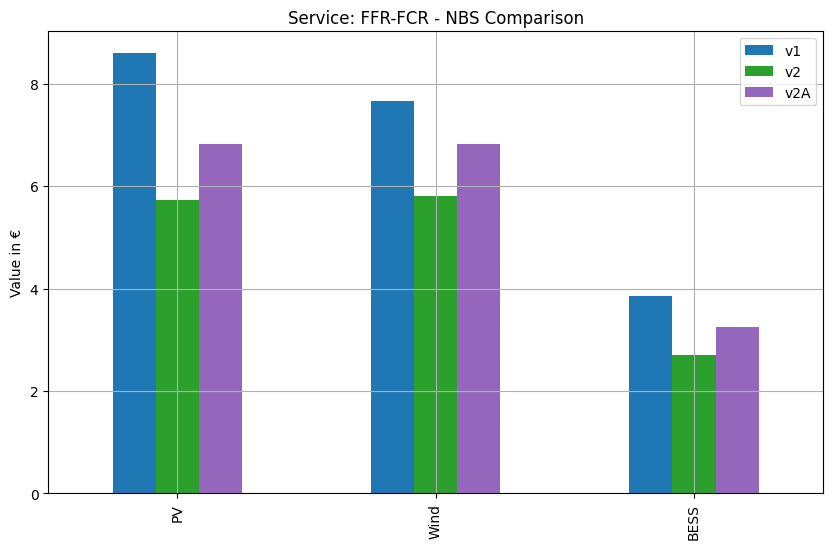

<Figure size 640x480 with 0 Axes>

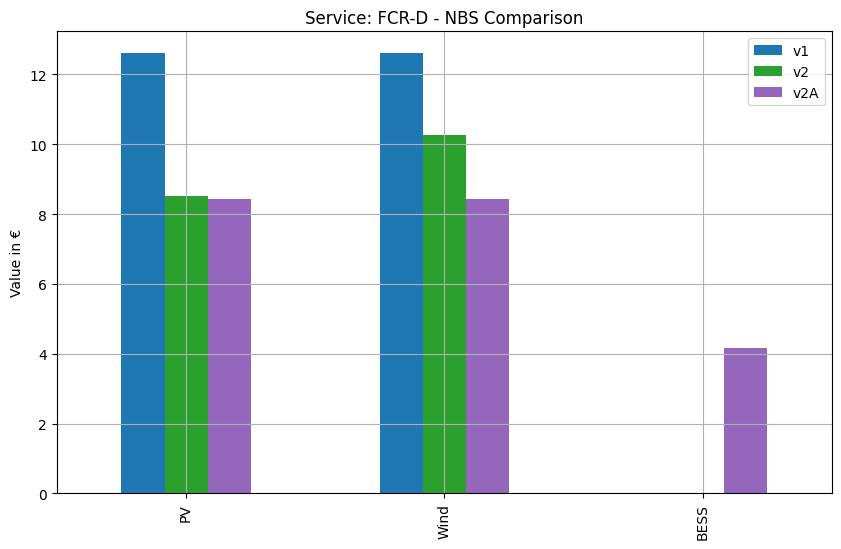

In [265]:
# NBS
dfs = [df_v1, df_v2, df_v2A]
cases = ['v1', 'v2', 'v2A']
names = [x[0] for x in df_v1.columns if len(x)==1]
# get new colors
colors = plt.cm.tab20(np.linspace(0, .4, len(cases)))
# plot to compare shapely value
for service in df_v1.index.get_level_values(0).unique():
    plt.figure()
    df_final = pd.DataFrame(0, index=names, columns=cases, dtype=float)
    for i, df in enumerate(dfs):
        df_plot = df.loc[service].loc['nbs'].dropna().astype(float)
        df_final.loc[:, cases[i]] = df_plot.values
    ax = df_final.plot(kind='bar', figsize=(10, 6),
                    title=f'Service: {service} - NBS Comparison', ylabel='Value in €',
                    color=colors)
    plt.grid()

### Nucleolus

C:\Users\carlv\AppData\Local\Temp\ipykernel_11520\1561283011.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final.loc[:, cases[i]] = df_plot.values
C:\Users\carlv\AppData\Local\Temp\ipykernel_11520\1561283011.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final.loc[:, cases[i]] = df_plot.values
C:\Users\carlv\AppData\Local\Temp\ipykernel_11520\1561283011.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final.loc[:, cases[i]] = df_plot.values


Could not plot nucleolus for FFR in case v1: Length of values (0) does not match length of index (3)
Could not plot nucleolus for FFR in case v2: Length of values (0) does not match length of index (3)
Could not plot nucleolus for FFR in case v2A: Length of values (0) does not match length of index (3)
Could not plot nucleolus for FCR-D in case v2: Length of values (0) does not match length of index (3)


C:\Users\carlv\AppData\Local\Temp\ipykernel_11520\1561283011.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final.loc[:, cases[i]] = df_plot.values


<Figure size 640x480 with 0 Axes>

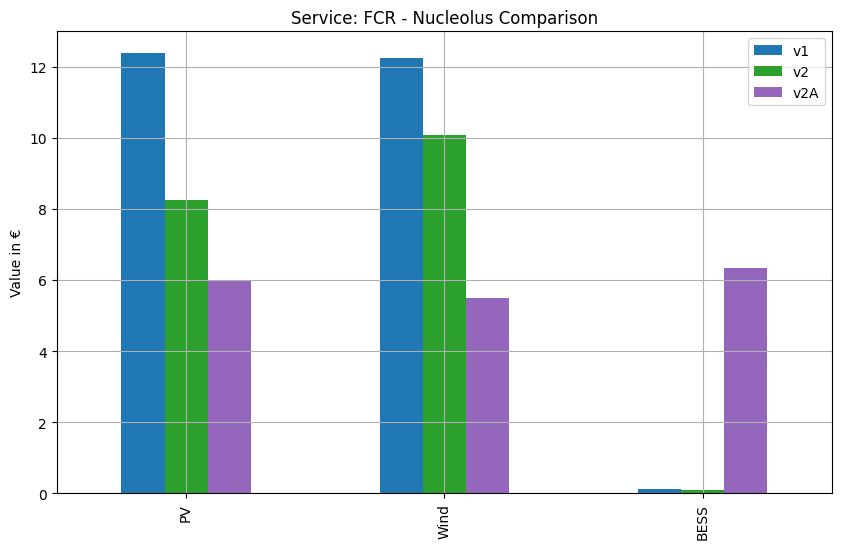

<Figure size 640x480 with 0 Axes>

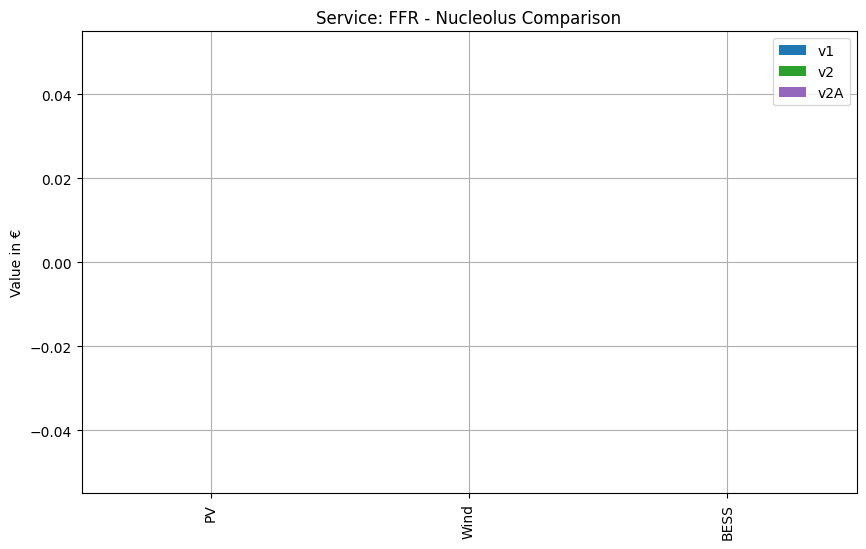

<Figure size 640x480 with 0 Axes>

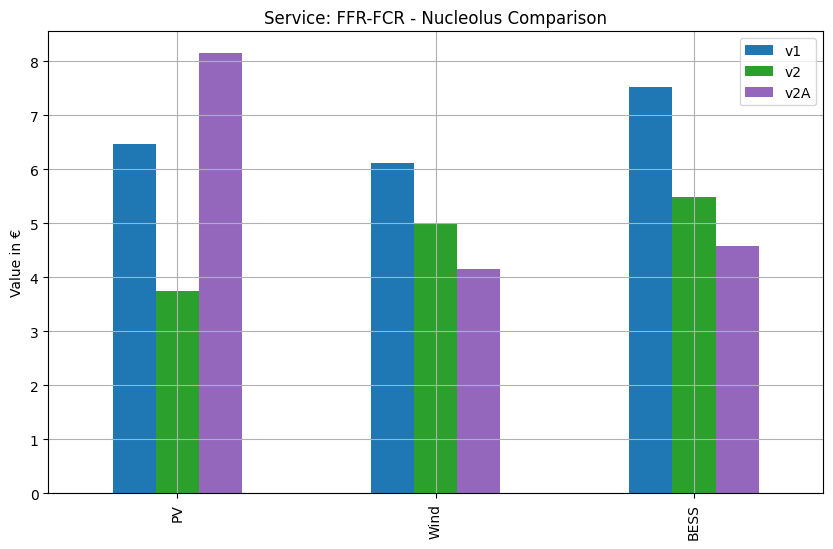

<Figure size 640x480 with 0 Axes>

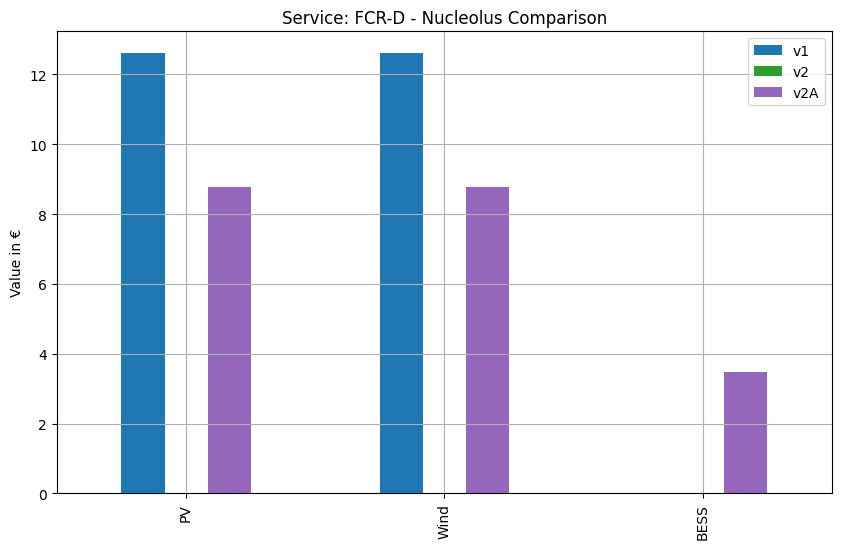

In [266]:
# compare Nucleolus
dfs = [df_v1, df_v2, df_v2A]
cases = ['v1', 'v2', 'v2A']
names = [x[0] for x in df_v1.columns if len(x)==1]
# plot to compare shapely value
for service in df_v1.index.get_level_values(0).unique():
    plt.figure()
    df_final = pd.DataFrame(0, index=names, columns=cases, dtype=float)
    for i, df in enumerate(dfs):
        try:
            df_plot = df.loc[service].loc['0. nucleolus'].dropna().astype(float)
            df_final.loc[:, cases[i]] = df_plot.values
        except Exception as e:
            print(f"Could not plot nucleolus for {service} in case {cases[i]}: {e}")
            continue
    ax = df_final.plot(kind='bar', figsize=(10, 6),
                    title=f'Service: {service} - Nucleolus Comparison', ylabel='Value in €',
                    color=colors)
    plt.grid()

### LOO

<Figure size 640x480 with 0 Axes>

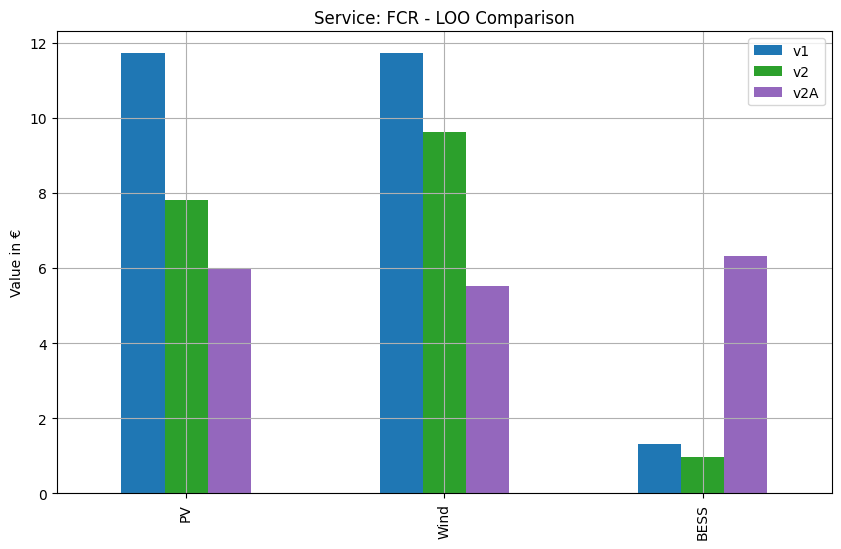

<Figure size 640x480 with 0 Axes>

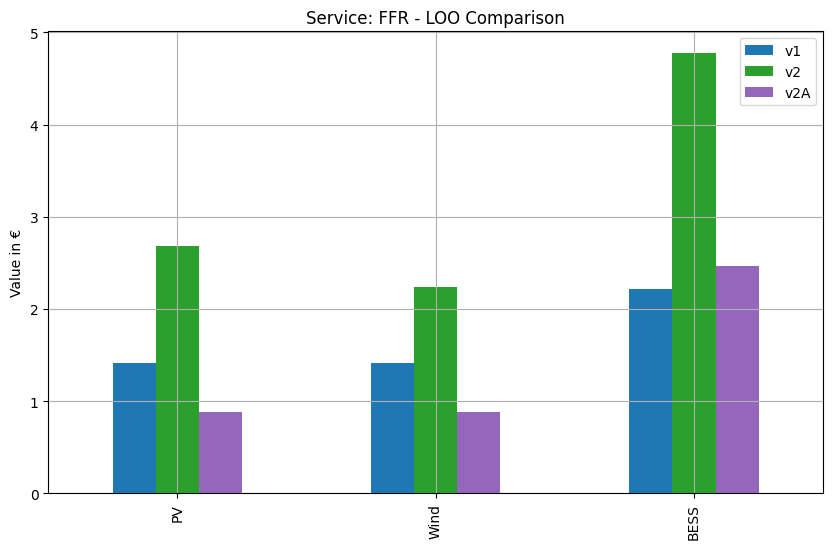

<Figure size 640x480 with 0 Axes>

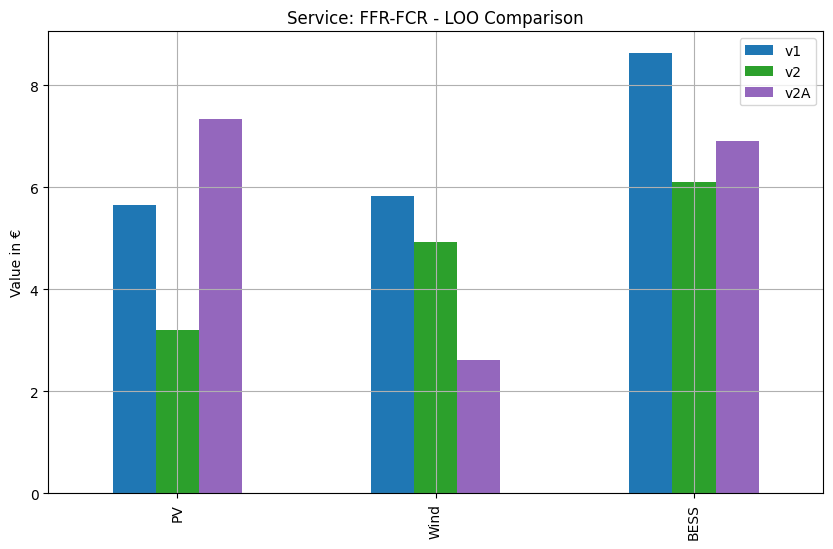

<Figure size 640x480 with 0 Axes>

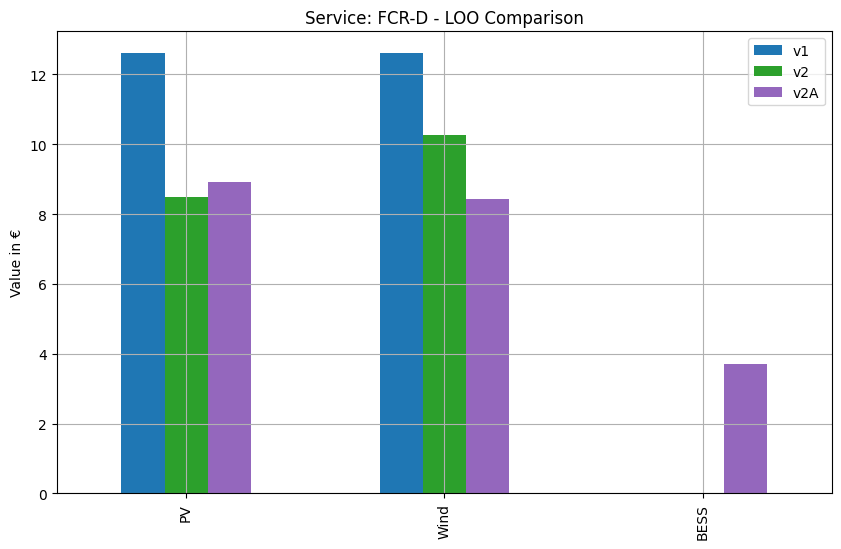

In [267]:
# compare LOO
dfs = [df_v1, df_v2, df_v2A]
cases = ['v1', 'v2', 'v2A']
names = [x[0] for x in df_v1.columns if len(x)==1]
# plot to compare shapely value
for service in df_v1.index.get_level_values(0).unique():
    plt.figure()
    df_final = pd.DataFrame(0, index=names, columns=cases, dtype=float)
    for i, df in enumerate(dfs):
        df_plot = df.loc[service].loc['loo'].dropna().astype(float)
        df_final.loc[:, cases[i]] = df_plot.values
    ax = df_final.plot(kind='bar', figsize=(10, 6),
                    title=f'Service: {service} - LOO Comparison', ylabel='Value in €',
                    color=colors)
    plt.grid()